# First Shot on Subtask A: Validation
Updated on August 1, 2021.

#### Project Information:
* Summer Project: Commonsense Validation and Explanation in Natural Language Processing<br>
* Objective Task: SemEval 2020 Task 4 - Commonsense Validation and Explanation (ComVE)<br>
* Supervisor: Dr Mark Lee<br>
* Student: Letian Li (2214560)
 
#### Task Description:
The subtask A is a validation task. The purpose is to determine which of two similar natural language statements is against common sense.

*Example:*  
> Task: Which of the two statements is against common sense?  
> Statement1: He put a turkey into the fridge.  
> Statement2: He put an elephant into the fridge. 

#### Solution:
This program will follow the steps:
1. General Preparation  
2. Data processing 
3. Load model and optimizer  
4. Training 
5. Test 

<!-- #### Task Description:
The subtask A is a validation task. The purpose is going to tell which of two similar natural language statements is against common sense.

*Example:* 
        
    Task: Which statement of the two is against common sense?
    Statement1: He put a turkey into the fridge.  
    Statement2: He put an elephant into the fridge.    -->

## 1. General Preparation

Import some common libraries.

In [10]:
from tqdm import tqdm
import time

Use GPU Facilities.

In [11]:
import torch
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## 2. Data processing

### 2.1 Read data from csv

Build a common function to get texts and labels from csv file.

In [12]:
import pandas as pd
def get_info_from_csv(texts_path, labels_path):
    texts = pd.read_csv(texts_path, header=0, names=['ID', 'Statement 0', 'Statement 1'])
    labels = pd.read_csv(labels_path, header=None, names=['ID', 'Answer'])
    return texts, labels

Read texts and labels from csv file.

In [13]:
train_texts, train_labels = get_info_from_csv(
    'ALL data/Training Data/subtaskA_data_all.csv',
    'ALL data/Training Data/subtaskA_answers_all.csv'
)

val_texts, val_labels = get_info_from_csv(
    'ALL data/Dev Data/subtaskA_dev_data.csv',
    'ALL data/Dev Data/subtaskA_gold_answers.csv'
)

test_texts, test_labels = get_info_from_csv(
    'ALL data/Test Data/subtaskA_test_data.csv',
    'ALL data/Test Data/subtaskA_gold_answers.csv'
)

Let's have a look at the training data.

In [14]:
train_data = pd.merge(train_texts, train_labels, how='left', on='ID')
train_data.head()

,ID,Statement 0,Statement 1,Answer
0,0,He poured orange juice on his cereal.,He poured milk on his cereal.,0
1,1,He drinks apple.,He drinks milk.,0
2,2,Jeff ran a mile today,"Jeff ran 100,000 miles today",1
3,3,A mosquito stings me,I sting a mosquito,1
4,4,A niece is a person.,A giraffe is a person.,1


Count the number of each answer separately.

In [15]:
print("Number of each answer：")
train_data['Answer'].value_counts()

Number of each answer：


1    5021
0    4979
Name: Answer, dtype: int64

### 2.2 Tokenization

In [16]:
from transformers import DistilBertTokenizerFast

# Get tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenization for texts
train_encodings = tokenizer(list(train_texts["Statement 0"]), list(train_texts["Statement 1"]), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts["Statement 0"]), list(val_texts["Statement 1"]), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts["Statement 0"]), list(test_texts["Statement 1"]), truncation=True, padding=True)

### 2.3 Turn data into a Dataset object

Define a Dataset class.

In [17]:
class ComVEDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Turn encodings and labels into a Dataset object.

In [18]:
# Adjust the labels
train_labels = train_labels['Answer']
val_labels = val_labels['Answer']
test_labels = test_labels['Answer']

# Turn encodings and labels into a Dataset object
train_dataset = ComVEDataset(train_encodings, train_labels)
val_dataset = ComVEDataset(val_encodings, val_labels)
test_dataset = ComVEDataset(test_encodings, test_labels)

## 3. Load model and optimizer

In [19]:
from transformers import DistilBertForSequenceClassification, AdamW

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device)

optim = AdamW(model.parameters(), lr=5e-5)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

## 4. Training

Prepare some utility functions.

In [20]:
# Prediction function
def predict(outputs):
    prediction = outputs["logits"].softmax(dim=1).argmax(dim=1, keepdim=True)
    return prediction

Training procedure

In [39]:
# Training
from torch.utils.data import DataLoader

def train(model, batch_size=16, epochs=10, optimizer=None, loss_function=None, target=None):
    # Set the number of epochs
    epochs = epochs

    # Get training data by DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Start training
    model.train()

    train_loss = list()
    for epoch in range(epochs):
        print('Epoch %s/%s' % (epoch + 1, epochs))
        time.sleep(0.3)

        correct = 0
        count = 0
        epoch_loss = list()

        pbar = tqdm(train_loader)
        for batch in pbar:
            optim.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            loss.backward()
            optim.step()

            # make a prediction
            prediction = predict(outputs)

            # count accuracy
            correct += prediction.eq(labels.view_as(prediction)).sum().item()
            count += len(labels)

            # show progress along with metrics
            pbar.set_postfix({
                'loss': '{:.3f}'.format(loss.item()),
                'accuracy': '{:.3f}'.format(correct * 1.0 / count)
            })

            # record the loss
            epoch_loss.append(loss.item())

        pbar.close()
        train_loss += epoch_loss
    
    return correct * 1.0 / count, train_loss[-1]

Visualise training loss.

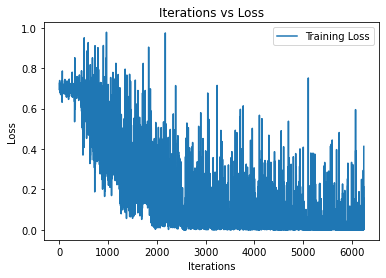

In [22]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")  
plt.legend()
plt.show()

## 5. Test

Test procedure

In [23]:
# Testing
from torch.utils.data import DataLoader

def test(model, batch_size=1)
    # Get test data by DataLoader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Start testing
    model.eval()

    with torch.no_grad():

        correct = 0
        count = 0
        record = list()

        pbar = tqdm(test_loader)
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]

            # make a prediction
            prediction = predict(outputs)

            # count accuracy
            correct += prediction.eq(labels.view_as(prediction)).sum().item()
            count += len(labels)

            # show progress along with metrics
            pbar.set_postfix({
                'loss': '{:.3f}'.format(loss.item()),
                'accuracy': '{:.3f}'.format(correct * 1.0 / count)
            })

            # record the results
            record.append((int(labels),int(prediction)))


        pbar.close()

100%|██████████| 1000/1000 [00:07<00:00, 125.93it/s, loss=0.000, accuracy=0.781]


Check the result.

In [24]:
# Show test result
for idx,item in enumerate(record):
    print("Statements %s:" % idx)
    print("Ground Truth:",item[0],"vs. Model Prediction:",item[1])

Statements 0:
Ground Truth: 0 vs. Model Prediction: 0
Statements 1:
Ground Truth: 0 vs. Model Prediction: 0
Statements 2:
Ground Truth: 0 vs. Model Prediction: 0
Statements 3:
Ground Truth: 0 vs. Model Prediction: 1
Statements 4:
Ground Truth: 1 vs. Model Prediction: 1
Statements 5:
Ground Truth: 0 vs. Model Prediction: 0
Statements 6:
Ground Truth: 1 vs. Model Prediction: 1
Statements 7:
Ground Truth: 0 vs. Model Prediction: 1
Statements 8:
Ground Truth: 0 vs. Model Prediction: 1
Statements 9:
Ground Truth: 1 vs. Model Prediction: 1
Statements 10:
Ground Truth: 0 vs. Model Prediction: 0
Statements 11:
Ground Truth: 0 vs. Model Prediction: 0
Statements 12:
Ground Truth: 0 vs. Model Prediction: 0
Statements 13:
Ground Truth: 1 vs. Model Prediction: 1
Statements 14:
Ground Truth: 1 vs. Model Prediction: 1
Statements 15:
Ground Truth: 1 vs. Model Prediction: 1
Statements 16:
Ground Truth: 0 vs. Model Prediction: 0
Statements 17:
Ground Truth: 0 vs. Model Prediction: 0
Statements 18:
Groun

Ground Truth: 0 vs. Model Prediction: 1
Statements 566:
Ground Truth: 0 vs. Model Prediction: 1
Statements 567:
Ground Truth: 0 vs. Model Prediction: 1
Statements 568:
Ground Truth: 1 vs. Model Prediction: 1
Statements 569:
Ground Truth: 1 vs. Model Prediction: 1
Statements 570:
Ground Truth: 0 vs. Model Prediction: 0
Statements 571:
Ground Truth: 0 vs. Model Prediction: 0
Statements 572:
Ground Truth: 1 vs. Model Prediction: 1
Statements 573:
Ground Truth: 1 vs. Model Prediction: 0
Statements 574:
Ground Truth: 0 vs. Model Prediction: 1
Statements 575:
Ground Truth: 0 vs. Model Prediction: 0
Statements 576:
Ground Truth: 1 vs. Model Prediction: 1
Statements 577:
Ground Truth: 0 vs. Model Prediction: 0
Statements 578:
Ground Truth: 0 vs. Model Prediction: 0
Statements 579:
Ground Truth: 1 vs. Model Prediction: 1
Statements 580:
Ground Truth: 0 vs. Model Prediction: 0
Statements 581:
Ground Truth: 0 vs. Model Prediction: 0
Statements 582:
Ground Truth: 1 vs. Model Prediction: 1
Statemen

<!-- # Convert test record to a pandas DataFrame object
from pandas.core.frame import DataFrame
df_record=DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

# Concat test texts and test records
df = pd.concat([test_texts, df_record], axis=1)

# Show test result
pd.set_option('display.max_rows', None)
df -->

In [26]:
# Manual Test
check_id = 999

test_data = list(test_loader)
check_target = test_data[check_id]
# print("check_target:",check_target)

input_ids = check_target['input_ids'].to(device)
attention_mask = check_target['attention_mask'].to(device)
labels = check_target['labels']
# print("input_ids:",input_ids)

statements_str = tokenizer.decode(input_ids[0],skip_special_tokens=False)
statements = statements_str.split("[CLS]")[1].split("[SEP]")
print("Task: Which statement of the two is against common sense?")
print("Statement 0:",statements[0])
print("Statement 1:",statements[1])
print()

outputs = model(input_ids, attention_mask=attention_mask)
prediction = predict(outputs)
print("Model Prediction:",int(prediction))
print("Ground Truth:",int(labels))

Task: Which statement of the two is against common sense?
Statement 0:  my friend runs for 2 inches every day. 
Statement 1:  my friend runs for 2 miles every day. 

Model Prediction: 0
Ground Truth: 0


## 6. Experiments 

In [41]:
import csv

"""
Experiment Different Hyperparameters with Grid Search method. 
"""
loss_name = 'CrossEntropy'
# loss_name = 'Tversky'

# optimizer_name = 'SGD'
optimizer_name = 'Adam'
# optimizer_name = 'AdaGrad'

# learning rate
lr_search_list = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]   # learning rate list
batch_search_list = [16,32,64]               # batch size list
epochs = 1
    
# Record the result into a CSV file
file_name = loss_name + "_" + optimizer_name + '.csv'

"""
Do Experiments with Different Hyperparameters
"""
with open(file_name, 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Learning Rate", "Batch Size","Epochs","Loss Function", "Optimizer", "Accuracy", "Validation Loss"])
    
    for lr in lr_search_list:
        print("Test for Learning Rate: ", lr)
        for batch_size in batch_search_list:
            print("Test for Batch Size: ", batch_size)
            
            # Initialize the model
#             model = get_model(model_name)
            model = model
            
            # Get Loss Function and Optimizer
#             loss_function = get_loss_function(loss_name)
#             optimizer = get_optimizer(model, optimizer_name, learning_rate)
            optimizer = optim
            
            # Train the model and get the validation result
            accuracy, val_loss = train(
                model = model,
                batch_size = batch_size,
                epochs = epochs,
                optimizer = optimizer,
#                 loss_function = loss_function
            )
            
            # Record the validation result 
            writer.writerow([lr, batch_size, epochs, loss_name, optimizer_name, accuracy, val_loss])

Test for Learning Rate:  1
Test for Batch Size:  16
Epoch 1/1


100%|██████████| 625/625 [00:26<00:00, 23.92it/s, loss=0.116, accuracy=0.993]


Test for Batch Size:  32
Epoch 1/1


100%|██████████| 313/313 [00:20<00:00, 15.00it/s, loss=0.000, accuracy=0.995]


Test for Batch Size:  64
Epoch 1/1


100%|██████████| 157/157 [00:18<00:00,  8.65it/s, loss=0.002, accuracy=0.998]


Test for Learning Rate:  0.1
Test for Batch Size:  16
Epoch 1/1


100%|██████████| 625/625 [00:26<00:00, 23.47it/s, loss=0.000, accuracy=0.994]


Test for Batch Size:  32
Epoch 1/1


100%|██████████| 313/313 [00:20<00:00, 15.15it/s, loss=0.004, accuracy=0.994]


Test for Batch Size:  64
Epoch 1/1


100%|██████████| 157/157 [00:17<00:00,  8.75it/s, loss=0.001, accuracy=0.997]


Test for Learning Rate:  0.01
Test for Batch Size:  16
Epoch 1/1


100%|██████████| 625/625 [00:26<00:00, 23.82it/s, loss=0.204, accuracy=0.992]


Test for Batch Size:  32
Epoch 1/1


100%|██████████| 313/313 [00:20<00:00, 15.31it/s, loss=0.001, accuracy=0.996]


Test for Batch Size:  64
Epoch 1/1


100%|██████████| 157/157 [00:17<00:00,  8.85it/s, loss=0.025, accuracy=0.998]


Test for Learning Rate:  0.001
Test for Batch Size:  16
Epoch 1/1


100%|██████████| 625/625 [00:26<00:00, 24.02it/s, loss=0.116, accuracy=0.996]


Test for Batch Size:  32
Epoch 1/1


100%|██████████| 313/313 [00:20<00:00, 15.29it/s, loss=0.002, accuracy=0.994]


Test for Batch Size:  64
Epoch 1/1


100%|██████████| 157/157 [00:17<00:00,  8.90it/s, loss=0.000, accuracy=0.999]


Test for Learning Rate:  0.0001
Test for Batch Size:  16
Epoch 1/1


100%|██████████| 625/625 [00:26<00:00, 24.00it/s, loss=0.001, accuracy=0.995]


Test for Batch Size:  32
Epoch 1/1


100%|██████████| 313/313 [00:20<00:00, 15.36it/s, loss=0.000, accuracy=0.998]


Test for Batch Size:  64
Epoch 1/1


100%|██████████| 157/157 [00:17<00:00,  8.88it/s, loss=0.000, accuracy=0.999]


Test for Learning Rate:  1e-05
Test for Batch Size:  16
Epoch 1/1


100%|██████████| 625/625 [00:26<00:00, 23.94it/s, loss=0.001, accuracy=0.996]


Test for Batch Size:  32
Epoch 1/1


100%|██████████| 313/313 [00:20<00:00, 15.48it/s, loss=0.001, accuracy=0.997]


Test for Batch Size:  64
Epoch 1/1


100%|██████████| 157/157 [00:17<00:00,  8.96it/s, loss=0.000, accuracy=0.999]


Test for Learning Rate:  1e-06
Test for Batch Size:  16
Epoch 1/1


100%|██████████| 625/625 [00:25<00:00, 24.11it/s, loss=0.006, accuracy=0.995]


Test for Batch Size:  32
Epoch 1/1


100%|██████████| 313/313 [00:20<00:00, 15.46it/s, loss=0.000, accuracy=0.997]


Test for Batch Size:  64
Epoch 1/1


100%|██████████| 157/157 [00:17<00:00,  8.90it/s, loss=0.134, accuracy=0.998]
